[INFO] FAST sample: 86335 rows (from 431675)

=== Validation Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9778 5.9817e-10 3.0778e-10
voltage_rise_time_pulse2 0.8971 1.4176e-09 7.4742e-10
voltage_fall_time_pulse1 0.9997 1.1882e-10 7.2650e-11
voltage_fall_time_pulse2 0.9997 1.1695e-10 7.1484e-11
current_rise_time_pulse1 0.9145 1.3734e-08 7.2784e-09
current_rise_time_pulse2 0.9027 8.3300e-09 4.2688e-09
current_fall_time_pulse1 0.9995 2.7532e-10 1.3283e-10
current_fall_time_pulse2 0.9997 2.2442e-10 1.3322e-10
       overshoot_pulse_1 0.9839 1.7160e+00 1.3418e+00
       overshoot_pulse_2 0.9401 6.5090e+00 4.9832e+00
      undershoot_pulse_1 0.9879 1.4828e+00 9.0251e-01
      undershoot_pulse_2 0.9881 1.4675e+00 8.9195e-01
   ringing_frequency_MHz 0.9990 9.9744e-01 7.0518e-01
R2_avg          0.9684
RMSE_avg    1.9740e+00
MAE_avg     6.7882e-01
dtype: object
Train Time (s): 48.1442
Predict Time (ms/sample): 0.1629


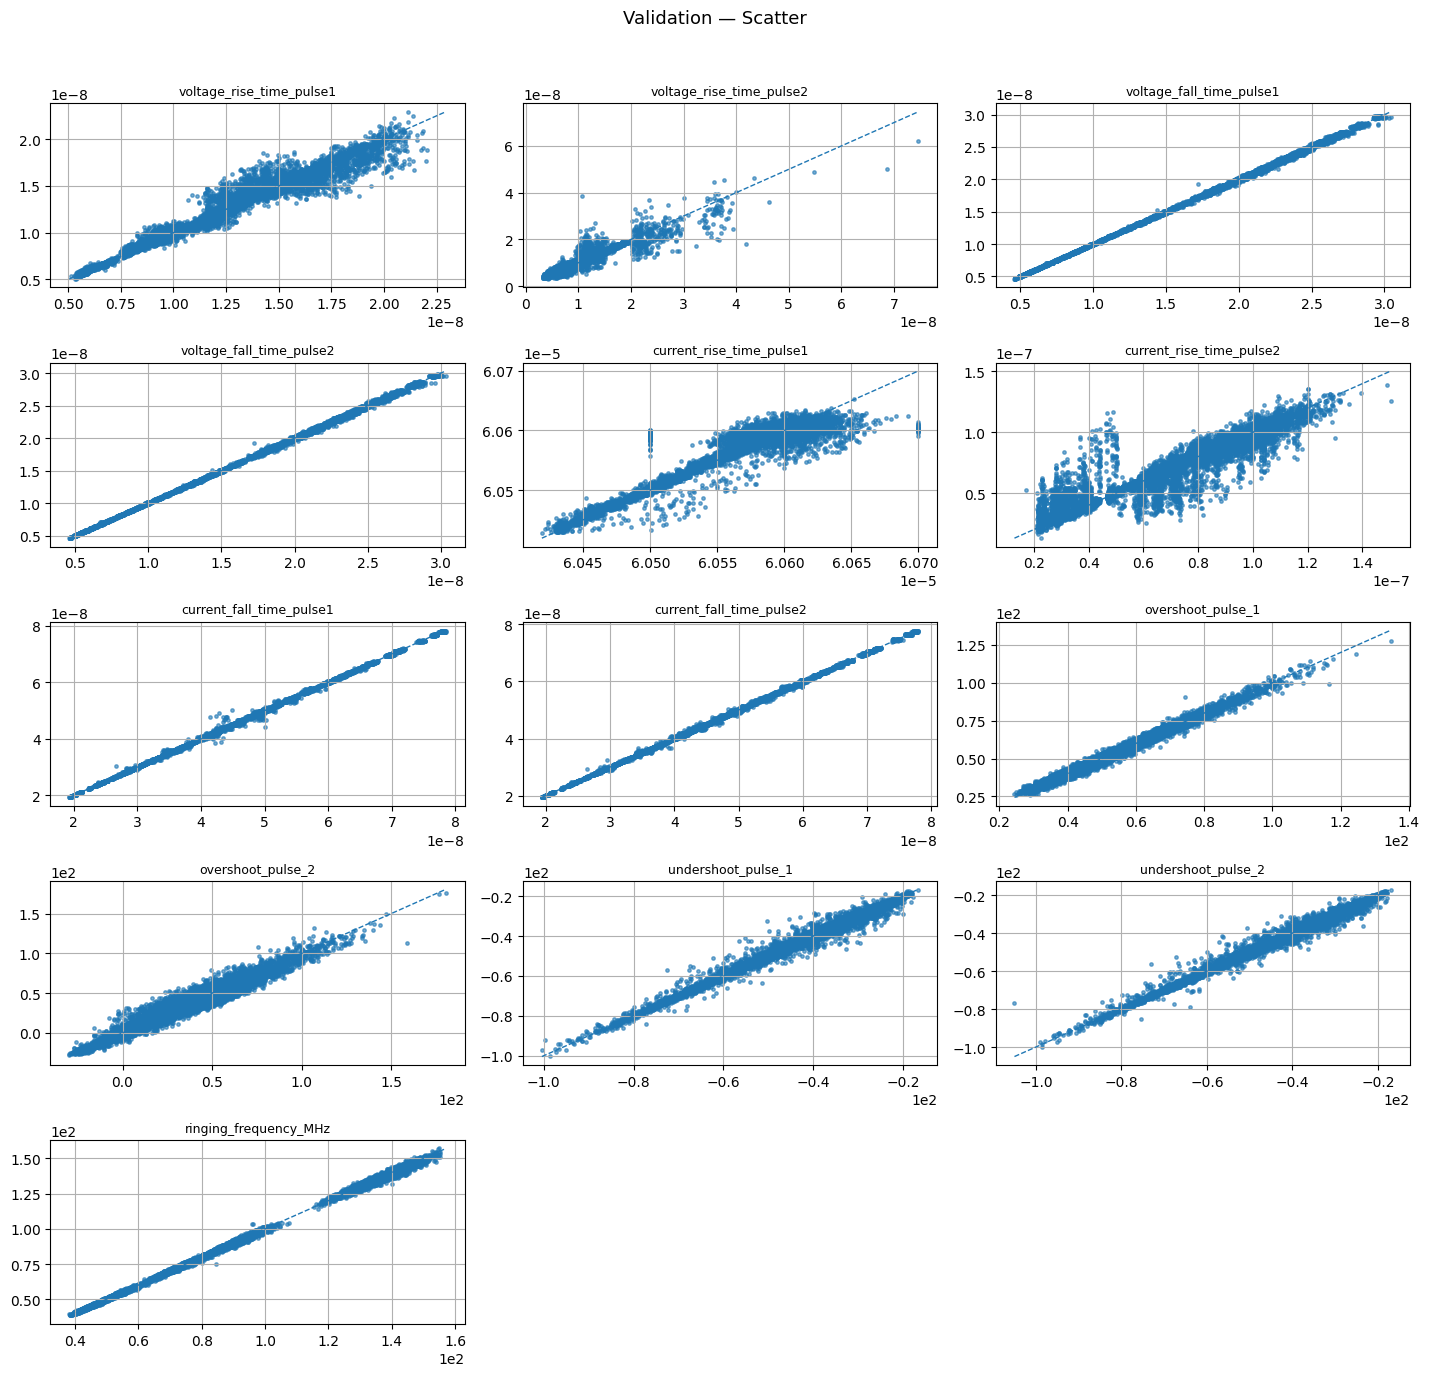


=== Test Set ===
                  Target     R2       RMSE        MAE
voltage_rise_time_pulse1 0.9779 5.9902e-10 3.1615e-10
voltage_rise_time_pulse2 0.8927 1.4730e-09 7.5232e-10
voltage_fall_time_pulse1 0.9997 1.1785e-10 7.2841e-11
voltage_fall_time_pulse2 0.9997 1.1791e-10 7.2612e-11
current_rise_time_pulse1 0.9224 1.3086e-08 7.0668e-09
current_rise_time_pulse2 0.9136 7.8448e-09 4.1340e-09
current_fall_time_pulse1 0.9996 2.6132e-10 1.3342e-10
current_fall_time_pulse2 0.9997 2.3410e-10 1.3422e-10
       overshoot_pulse_1 0.9829 1.7778e+00 1.3493e+00
       overshoot_pulse_2 0.9434 6.3754e+00 4.8463e+00
      undershoot_pulse_1 0.9872 1.5255e+00 9.1056e-01
      undershoot_pulse_2 0.9891 1.4086e+00 8.8772e-01
   ringing_frequency_MHz 0.9990 9.9778e-01 7.1250e-01
R2_avg          0.9698
RMSE_avg    1.9437e+00
MAE_avg     6.6972e-01
dtype: object
Predict Time (ms/sample): 0.1862


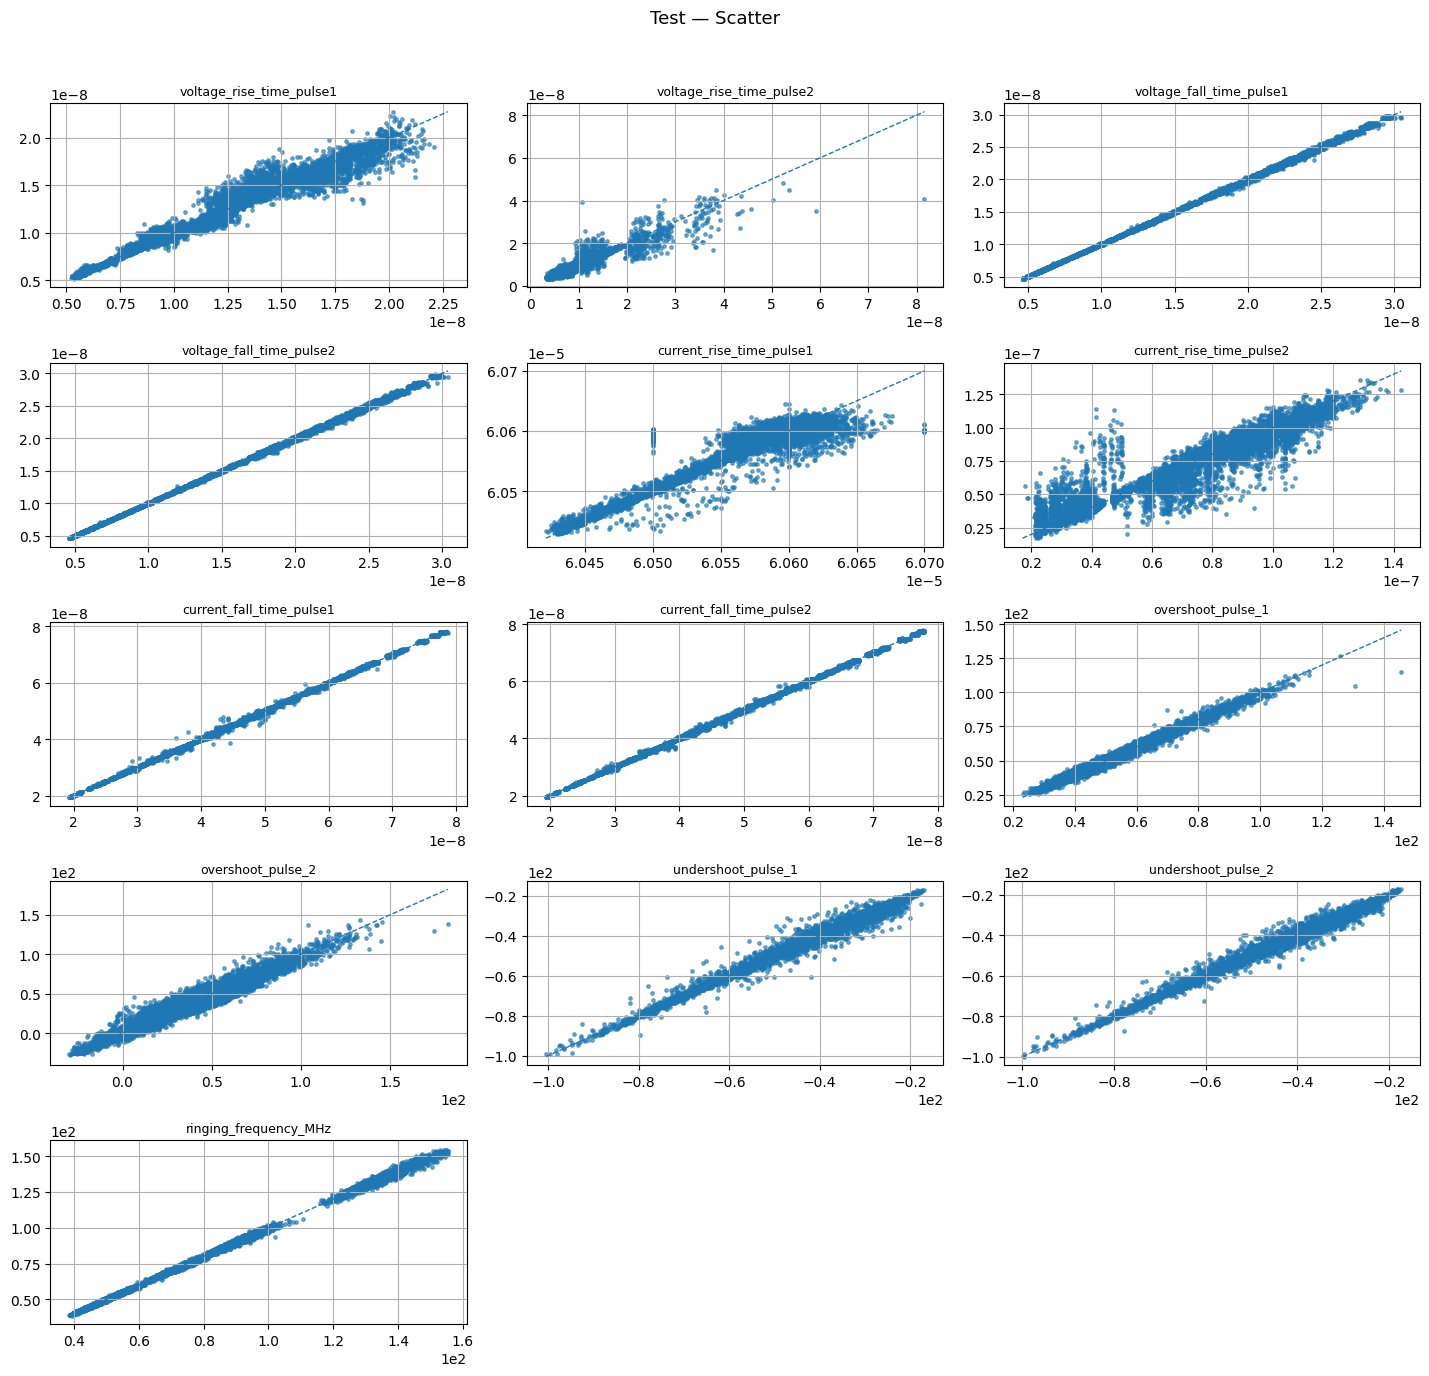

In [2]:
# xgb_baseline_clean.py
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

# ===================== Config =====================
TRAIN_FILE = r"C:\Users\pc\Desktop\Classical_Models\MERGED_ORIGINAL\Train_5_MOSFETs.csv"

RANDOM_STATE = 42
FAST_FRAC = 0.25          # 25% per (Vbus..Ls11) combo
GRID_COLS  = 3            # scatter grid columns

USE_NOISE_AUG = False     # keep OFF for stability; turn on only if needed
NOISE_STD_PCT = 0.03
NOISE_FRAC    = 0.50
# ==================================================

TARGETS = [
    'voltage_rise_time_pulse1','voltage_rise_time_pulse2',
    'voltage_fall_time_pulse1','voltage_fall_time_pulse2',
    'current_rise_time_pulse1','current_rise_time_pulse2',
    'current_fall_time_pulse1','current_fall_time_pulse2',
    'overshoot_pulse_1','overshoot_pulse_2',
    'undershoot_pulse_1','undershoot_pulse_2',
    'ringing_frequency_MHz'
]
COMBO_COLS = ["Vbus","Rg","Ls4","Ls5","Ls6","Ls7","Ls8","Ls9","Ls10","Ls11"]

# ---- helpers ----
def encode_part_number(df):
    if "Part_Number" in df.columns:
        le = LabelEncoder()
        df["Part_Number"] = le.fit_transform(df["Part_Number"].astype(str))
    return df

def sample_by_combo(df, combo_cols, frac=0.25, random_state=42):
    """Sample a fraction within each unique combo (no groupby.apply)."""
    rng = np.random.default_rng(random_state)
    parts = []
    for _, g in df.groupby(combo_cols, dropna=False, sort=False):
        n = max(1, int(round(frac * len(g))))
        n = min(n, len(g))
        idx = rng.choice(g.index.to_numpy(), size=n, replace=False)
        parts.append(df.loc[idx])
    return pd.concat(parts, axis=0).sort_index().reset_index(drop=True)

def augment_with_noise(df, feature_cols, std_pct=0.03, frac=0.5, seed=42, exclude_cols=None):
    """Optional: add noisy copies; keeps dtypes float by casting features before adding noise."""
    exclude_cols = set(exclude_cols or [])
    noise_cols = [c for c in feature_cols if c not in exclude_cols]
    if not noise_cols:
        return df
    rng = np.random.default_rng(seed)
    n_extra = max(1, int(round(frac * len(df))))
    idx = rng.choice(df.index.to_numpy(), size=n_extra, replace=True)
    aug = df.loc[idx].copy()
    # cast to float BEFORE adding noise to avoid dtype issues
    for c in noise_cols:
        aug[c] = aug[c].astype(np.float32)
    col_std = df[noise_cols].astype(np.float32).std(ddof=0).replace(0.0, 1e-12)
    noise = rng.normal(0.0, (col_std.values * std_pct), size=(len(aug), len(noise_cols)))
    aug.loc[:, noise_cols] = aug[noise_cols].to_numpy() + noise
    return pd.concat([df, aug], axis=0).reset_index(drop=True)

def split_70_15_15(X, y, seed=RANDOM_STATE):
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=seed, shuffle=True)
    X_val, X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, random_state=seed, shuffle=True)
    return X_train, X_val, X_test, y_train, y_val, y_test

def train_xgb_multioutput(X_train, y_train_scaled, seed=RANDOM_STATE):
    base = XGBRegressor(
        n_estimators=600,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1.0,
        reg_lambda=1.0,
        objective="reg:squarederror",
        tree_method="hist",
        n_jobs=-1,
        random_state=seed,
    )
    model = MultiOutputRegressor(base, n_jobs=-1)
    t0 = time.time()
    model.fit(X_train, y_train_scaled)
    train_time = time.time() - t0
    return model, train_time

def predict_with_timing(model, X):
    t0 = time.time()
    y_pred_scaled = model.predict(X)
    ms_per_sample = (time.time() - t0) / len(X) * 1000.0
    return y_pred_scaled, ms_per_sample

def compute_metrics(y_true, y_pred):
    rows = []
    for i, t in enumerate(TARGETS):
        yt, yp = y_true[:, i], y_pred[:, i]
        rows.append([
            t,
            r2_score(yt, yp),
            np.sqrt(mean_squared_error(yt, yp)),
            mean_absolute_error(yt, yp)
        ])
    df = pd.DataFrame(rows, columns=["Target", "R2", "RMSE", "MAE"])
    overall = {
        "R2_avg":  r2_score(y_true, y_pred, multioutput="uniform_average"),
        "RMSE_avg":np.sqrt(mean_squared_error(y_true, y_pred)),
        "MAE_avg": mean_absolute_error(y_true, y_pred),
    }
    return df, overall

def format_metrics(df_metrics, overall):
    df_fmt = df_metrics.copy()
    df_fmt["R2"]   = df_fmt["R2"].map(lambda x: f"{x:.4f}")
    df_fmt["RMSE"] = df_fmt["RMSE"].map(lambda x: f"{x:.4e}")
    df_fmt["MAE"]  = df_fmt["MAE"].map(lambda x: f"{x:.4e}")
    overall_fmt = {
        "R2_avg":  f"{overall['R2_avg']:.4f}",
        "RMSE_avg":f"{overall['RMSE_avg']:.4e}",
        "MAE_avg": f"{overall['MAE_avg']:.4e}",
    }
    return df_fmt, overall_fmt

def scatter_grid(y_true, y_pred, target_names, title, n_cols=3):
    n_targets = len(target_names)
    n_rows = int(np.ceil(n_targets / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.8*n_cols, 2.8*n_rows))
    axes = axes.flatten()
    for i, t in enumerate(target_names):
        ax = axes[i]
        ax.scatter(y_true[:, i], y_pred[:, i], s=6, alpha=0.6)
        mn = min(y_true[:, i].min(), y_pred[:, i].min())
        mx = max(y_true[:, i].max(), y_pred[:, i].max())
        ax.plot([mn, mx], [mn, mx], '--', lw=1)
        ax.set_title(t, fontsize=9)
        ax.grid(True)
        ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.suptitle(title, fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# ---- main ----
def main():
    # Load & light clean
    df = pd.read_csv(TRAIN_FILE).dropna().reset_index(drop=True)
    df = encode_part_number(df)

    # FAST sample per (Vbus..Ls11)
    df_fast = sample_by_combo(df, COMBO_COLS, frac=FAST_FRAC, random_state=RANDOM_STATE)
    print(f"[INFO] FAST sample: {len(df_fast)} rows (from {len(df)})")

    # Feature list & (optional) noise aug
    feature_cols = [c for c in df_fast.columns if c not in TARGETS]
    if USE_NOISE_AUG:
        df_fast = augment_with_noise(df_fast, feature_cols, NOISE_STD_PCT, NOISE_FRAC, RANDOM_STATE, exclude_cols=["Part_Number"])
        print(f"[INFO] After noise augmentation: {len(df_fast)} rows")

    # Force features to float32 for XGBoost stability
    for c in feature_cols:
        df_fast[c] = df_fast[c].astype(np.float32)

    # Arrays
    X = df_fast[feature_cols].to_numpy(dtype=np.float32)
    y = df_fast[TARGETS].to_numpy(dtype=np.float32)

    # Split
    X_tr, X_va, X_te, y_tr, y_va, y_te = split_70_15_15(X, y)

    # Per-target scaler on y (fit ONLY on train), then inverse-transform for metrics
    y_scaler = StandardScaler()
    y_tr_s = y_scaler.fit_transform(y_tr)
    y_va_s = y_scaler.transform(y_va)
    y_te_s = y_scaler.transform(y_te)

    # Train XGB (multioutput wrapper)
    model, train_time = train_xgb_multioutput(X_tr, y_tr_s)

    # Validation
    y_va_pred_s, va_ms = predict_with_timing(model, X_va)
    y_va_pred = y_scaler.inverse_transform(y_va_pred_s)
    va_df, va_over = compute_metrics(y_va, y_va_pred)
    va_df_f, va_over_f = format_metrics(va_df, va_over)

    print("\n=== Validation Set ===")
    print(va_df_f.to_string(index=False))
    print(pd.Series(va_over_f))
    print(f"Train Time (s): {train_time:.4f}")
    print(f"Predict Time (ms/sample): {va_ms:.4f}")
    scatter_grid(y_va, y_va_pred, TARGETS, "Validation — Scatter", n_cols=GRID_COLS)

    # Test
    y_te_pred_s, te_ms = predict_with_timing(model, X_te)
    y_te_pred = y_scaler.inverse_transform(y_te_pred_s)
    te_df, te_over = compute_metrics(y_te, y_te_pred)
    te_df_f, te_over_f = format_metrics(te_df, te_over)

    print("\n=== Test Set ===")
    print(te_df_f.to_string(index=False))
    print(pd.Series(te_over_f))
    print(f"Predict Time (ms/sample): {te_ms:.4f}")
    scatter_grid(y_te, y_te_pred, TARGETS, "Test — Scatter", n_cols=GRID_COLS)

if __name__ == "__main__":
    main()
